In [1]:
from typing import Tuple
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

from colors import final_color, cv_color
from constants import KINGDOMS
from evaluation.serialization import Serializer

In [55]:
cv_final_metrics = Serializer.load("cv_metrics")
final_metrics = Serializer.load("final_metrics")

# Preserve label order
final_metrics["label"] = pd.Categorical(final_metrics["label"], ["overall", 'S', 'L', 'T', 'I', 'M', 'O'])
cv_final_metrics["label"] = pd.Categorical(cv_final_metrics["label"], ["overall", 'S', 'L', 'T', 'I', 'M', 'O'])

In [57]:
final_data = final_metrics\
    .query("kingdom != 'overall'")\
    .groupby(["metric", "kingdom", "label"])\
    .agg(["mean", "std"])\
    ["value"]
final_data["ci"] = 1.96 * final_data["std"]

In [58]:
cv_average_data = cv_final_metrics\
    .query("kingdom != 'overall'")\
    .groupby(["metric", "kingdom", "label"])\
    .agg(["mean", "std"])\
    ["value"]

cv_average_data["ci"] = 1.96 * cv_average_data["std"] / 2

,,,mean,std,ci
metric,kingdom,label,,,


In [75]:
final_data.query("metric == 'recall'").sort_values(by=["mean"])

mean       std        ci
metric kingdom  label                                
recall EUKARYA  L        0.000000  0.000000  0.000000
                T        0.000000  0.000000  0.000000
       ARCHAEA  M        0.693206  0.090295  0.176978
       POSITIVE T        0.724318  0.087281  0.171071
                M        0.771689  0.049587  0.097190
       NEGATIVE M        0.781787  0.030658  0.060090
                S        0.790984  0.033976  0.066594
       EUKARYA  M        0.791261  0.020316  0.039819
       ARCHAEA  L        0.802691  0.191711  0.375753
       POSITIVE overall  0.837939  0.022127  0.043369
                S        0.851447  0.048214  0.094500
       ARCHAEA  overall  0.853563  0.038346  0.075157
                T        0.860981  0.125660  0.246293
       NEGATIVE I        0.871299  0.032084  0.062884
                overall  0.877443  0.011570  0.022677
       EUKARYA  overall  0.892232  0.006325  0.012398
       POSITIVE I        0.895071  0.040605  0.079586
       EUKARYA  S        0.914409  0.010932  0.021427
                O        0.914953  0.009222  0.018076
       POSITIVE O        0.931943  0.015219  0.029828
                L        0.933632  0.020403  0.039989
       ARCHAEA  O        0.935707  0.019301  0.037831
                S        0.947169  0.043651  0.085556
       NEGATIVE O        0.953121  0.007869  0.015424
                T        0.955846  0.010538  0.020654
                L        0.956453  0.012700  0.024892
       ARCHAEA  I        0.960287  0.017145  0.033604
       EUKARYA  I        0.985950  0.001668  0.003269

In [ ]:
final_data.query("mean > 0 and metric == 'recall' and label == @annotations").sort_values(by=["mean"])

In [80]:
final_data.query("mean > 0 and metric == 'mcc' and label == @annotations").sort_values(by=["mean"])

mean       std        ci
metric kingdom  label                              
mcc    POSITIVE T      0.725803  0.062874  0.123233
                S      0.739063  0.047512  0.093124
       ARCHAEA  S      0.743272  0.087673  0.171839
                L      0.752880  0.153847  0.301540
       NEGATIVE S      0.801019  0.027901  0.054687
       EUKARYA  S      0.893146  0.008010  0.015700
       ARCHAEA  T      0.898730  0.071676  0.140486
       NEGATIVE L      0.921317  0.011590  0.022717
       POSITIVE L      0.924216  0.019941  0.039085
       NEGATIVE T      0.954543  0.007992  0.015664

UndefinedVariableError: local variable 'annotations' is not defined

In [10]:
with open("../data/kingdom_distribution.pickle", "rb") as f:
    proportions = pickle.load(f)

In [71]:
final_data.query(f"kingdom == '{kingdom}' and metric == 'mcc' and label == @annotations")["mean"].sort_values(key=reorder),
final_data.reindex(["S", "L", "T"])

MultiIndex([('mcc', 'NEGATIVE', 'S'),
            ('mcc', 'NEGATIVE', 'T'),
            ('mcc', 'NEGATIVE', 'L')],
           names=['metric', 'kingdom', 'label'])


,mean,std,ci
S,NaN,NaN,NaN
L,NaN,NaN,NaN
T,NaN,NaN,NaN


In [43]:
final_data.query(f"kingdom == '{kingdom}' and metric == 'mcc' and label == @annotations")["mean"]


metric  kingdom  label  
mcc     EUKARYA  S          0.893146
                 L          0.000000
                 T          0.000000
                 overall    0.900886
Name: mean, dtype: float64

## Plot

In [45]:
sns.set_theme()
matplotlib.rcParams.update({"errorbar.capsize": 5})

### Only signal peptides (S/T/L)


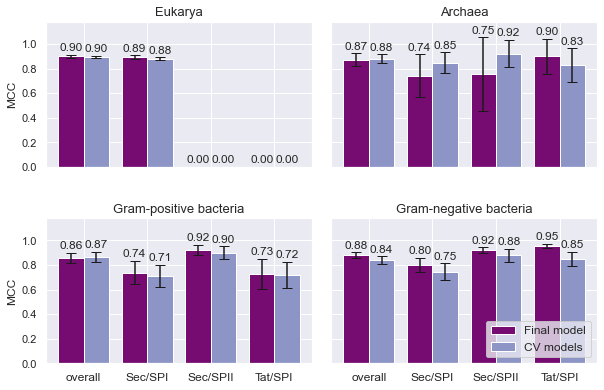

In [73]:
bar_width = 0.4
annotations = ["overall", 'S', 'L', 'T']
labels = {"overall": "overall", 'S': "Sec/SPI", 'L': "Sec/SPII", 'T': "Tat/SPI"}
# {'I': "Cytoplasmic", 'M': "Transmembrane", 'O': "Extracellular"}
kingdom_labels = {"ARCHAEA": "Archaea", "POSITIVE": "Gram-positive bacteria", "NEGATIVE": "Gram-negative bacteria", "EUKARYA": "Eukarya"}
r1 = np.arange(len(labels))
r2 = r1 + bar_width

fig = plt.figure()
gs = fig.add_gridspec(2,2)

((ax1, ax2), (ax3, ax4)) = gs.subplots(sharex="col", sharey="row")
for ax, kingdom in zip([ax1, ax2, ax3, ax4], KINGDOMS):
    ax.set_title(kingdom_labels[kingdom], fontsize=13)

    final_values = ax.bar(
        r1,
        final_data.query(f"kingdom == '{kingdom}' and metric == 'mcc' and label == @annotations")["mean"],
        yerr=final_data.query(f"kingdom == '{kingdom}' and metric == 'mcc' and label == @annotations")["ci"],
        width=bar_width,
        color=final_color,
        label="Final model"
    )
    cv_values = ax.bar(
        r2,
        cv_average_data.query(f"kingdom == '{kingdom}' and metric == 'mcc' and label == @annotations")["mean"],
        yerr=cv_average_data.query(f"kingdom == '{kingdom}' and metric == 'mcc' and label == @annotations")["ci"],
        width=bar_width,
        color=cv_color,
        label="CV models"
    )

    ax.set_ylabel("MCC", fontsize=12)
    ax.set_xticks(r1 + bar_width/2)
    ax.set_xticklabels(labels.values(), fontsize=12)
    ax.set_ylim([0.0, 1.18])
    ax.label_outer()

    ax.bar_label(final_values, padding=2, fmt="%.2f")
    ax.bar_label(cv_values, padding=2, fmt="%.2f")

plt.legend(loc="lower right", fontsize=12)
fig.tight_layout()
fig.set_size_inches(9, 6)
fig.savefig("output/rnn_per_residue_performance.png", dpi=300)

### All combinations

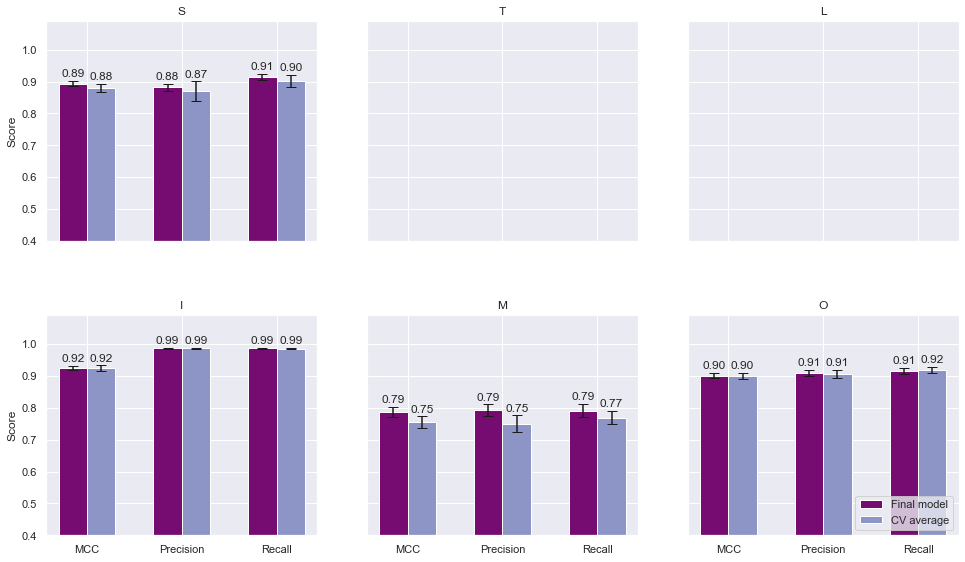

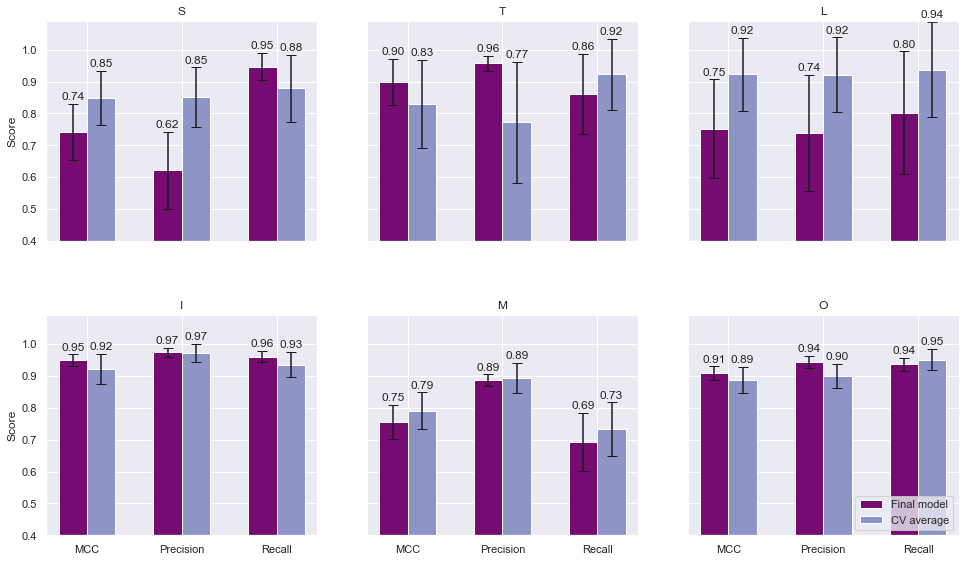

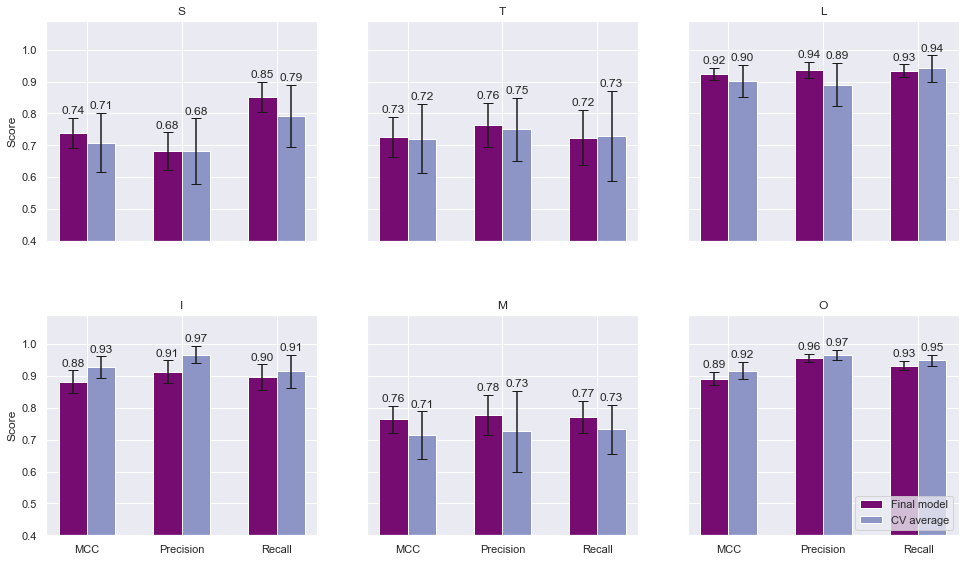

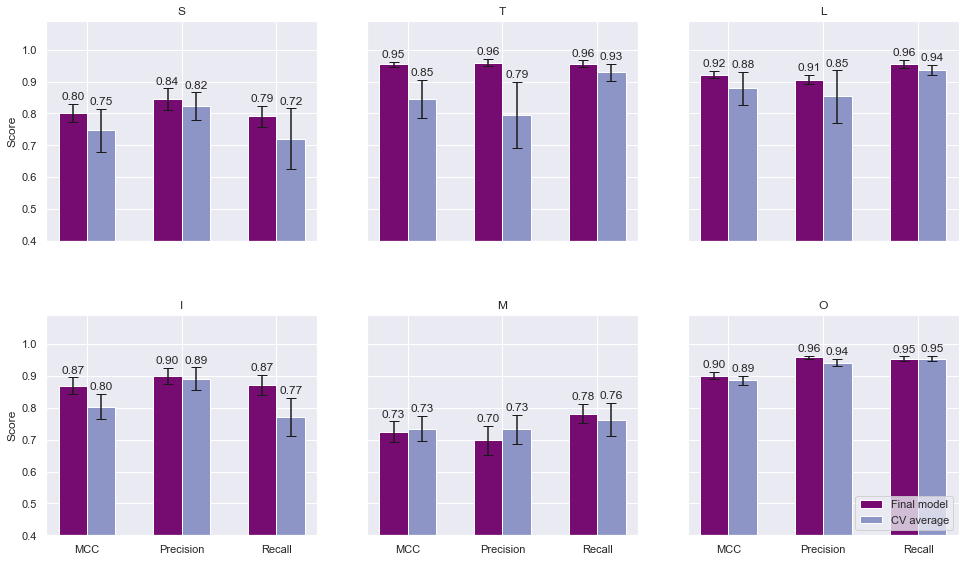

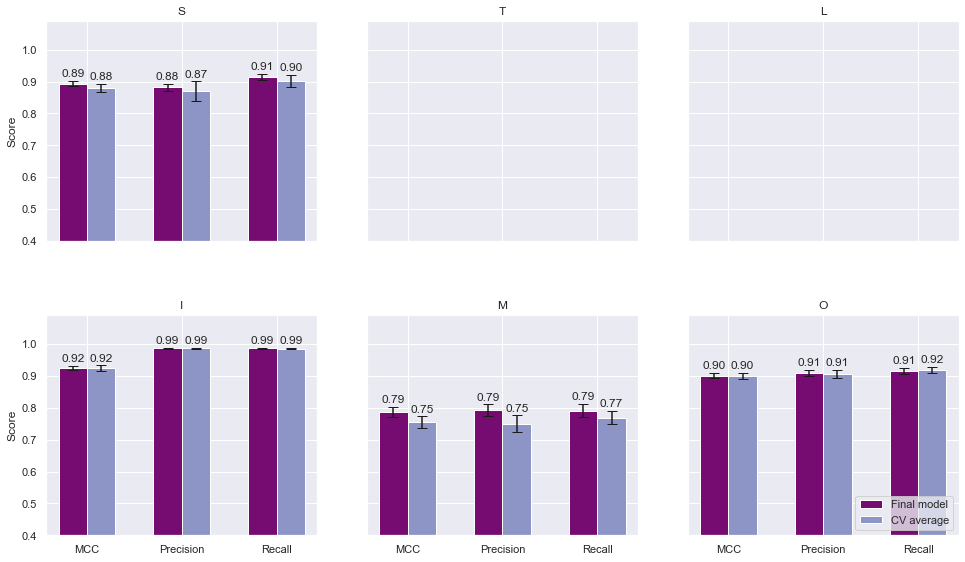

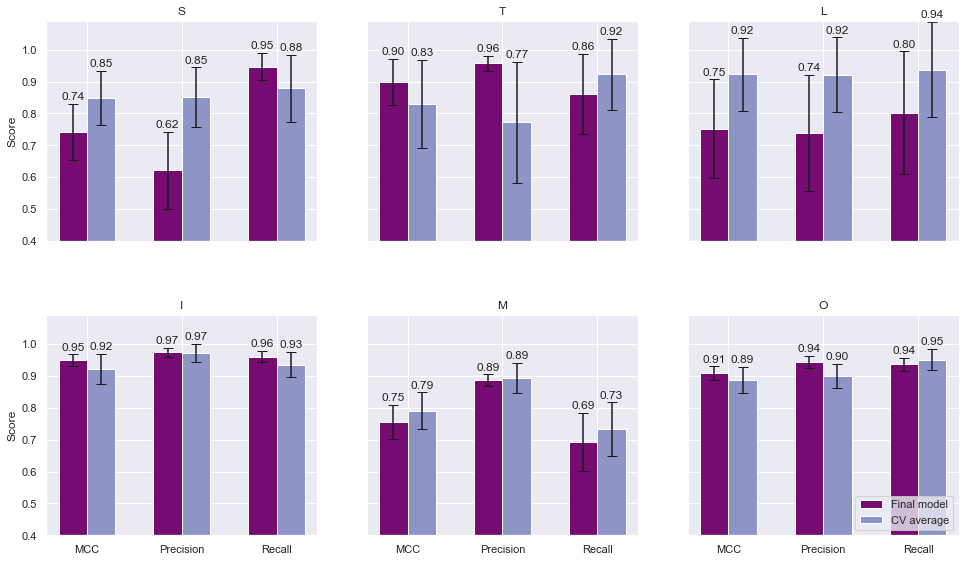

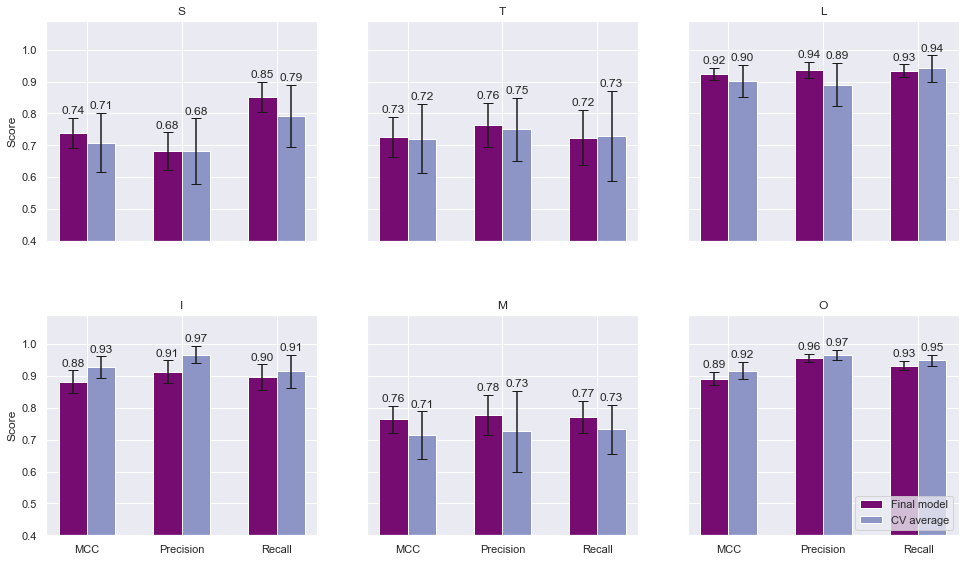

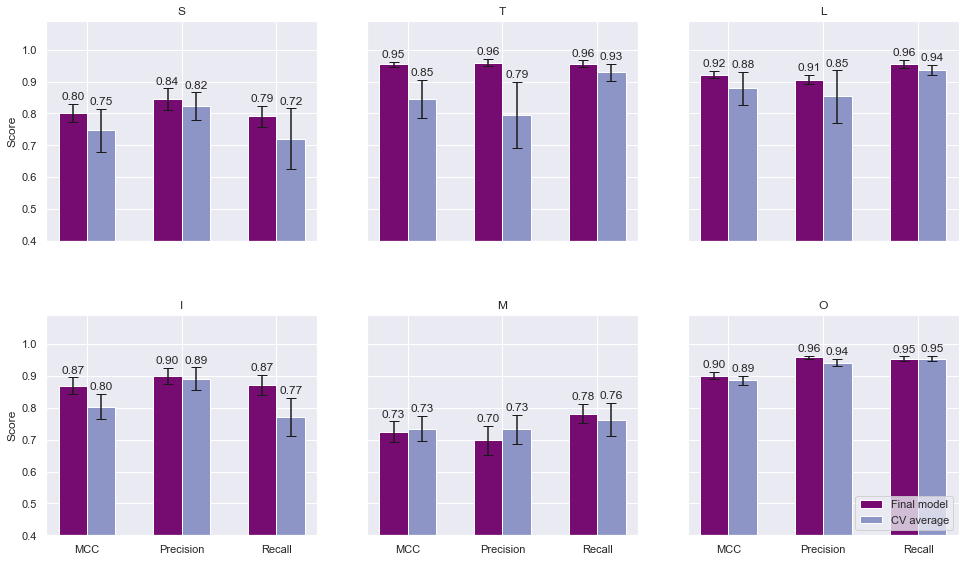

In [14]:

bar_width = 0.3
metrics = ["mcc", "precision", "recall"]
labels = ["MCC", "Precision", "Recall"]
classes = [c for c in "STLIMO"]
r1 = np.arange(len(metrics))
r2 = r1 + bar_width

for kingdom in KINGDOMS:
    fig = plt.figure()
    #fig.suptitle(kingdom)
    gs = fig.add_gridspec(2, 3)
    ((ax1, ax2, ax3), (ax4, ax5, ax6)) = gs.subplots(sharex="col", sharey="row")
    for ax, label in zip([ax1, ax2, ax3, ax4, ax5, ax6], classes):
        ax.set_title(label)
        final_values = ax.bar(
            r1,
            final_data.query(f"kingdom == '{kingdom}' and label == '{label}'")["mean"],
            yerr=final_data.query(f"kingdom == '{kingdom}' and label == '{label}'")["std"],
            width=bar_width,
            color=final_color,
            label="Final model"
        )

        cv_values = ax.bar(
            r2,
            cv_average_data.query(f"kingdom == '{kingdom}' and label == '{label}'")["mean"],
            yerr=cv_average_data.query(f"kingdom == '{kingdom}' and label == '{label}'")["std"],
            width=bar_width,
            color=cv_color,
            label="CV average"
        )

        ax.set_ylabel("Score")
        ax.set_xticks(r1 + bar_width/2)
        ax.set_xticklabels(labels)
        ax.set_ylim([0.4, 1.09])
        ax.label_outer()

        ax.bar_label(final_values, padding=2, fmt="%.2f")
        ax.bar_label(cv_values, padding=2, fmt="%.2f")

    plt.legend(loc="lower right")
    fig.tight_layout()
    fig.set_size_inches(15, 9)
    fig.savefig(f"output/performance_by_label_for_{kingdom}.png", dpi=240)

### Selected Combinations

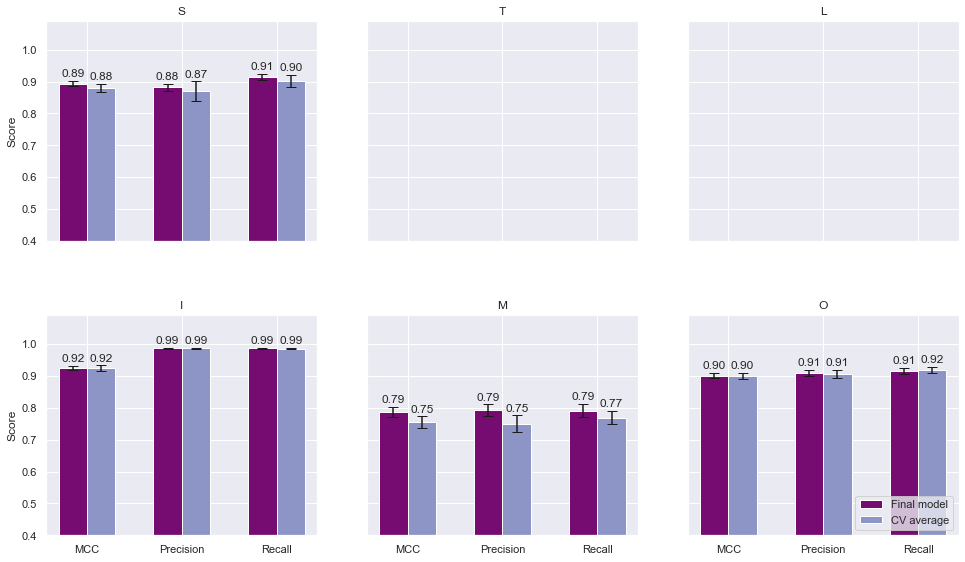

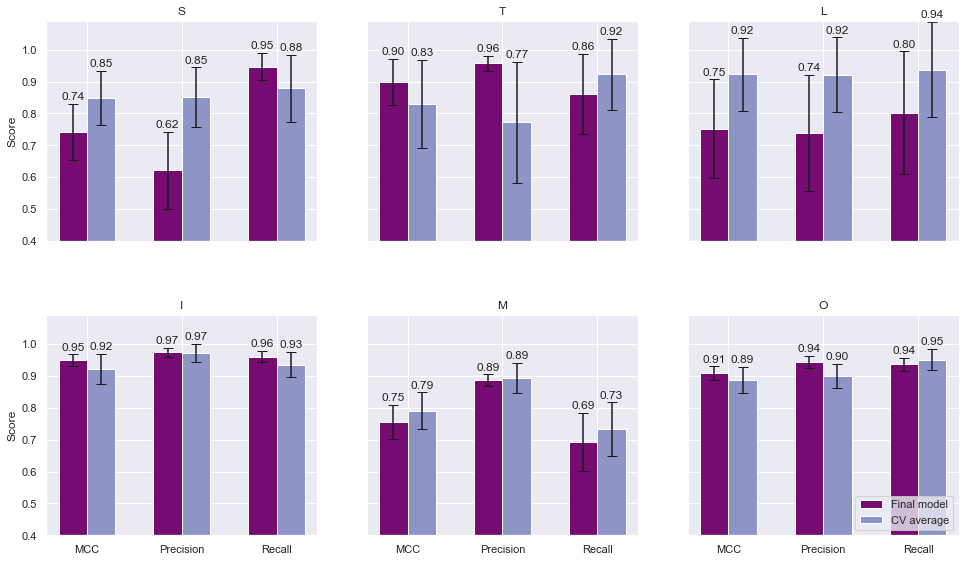

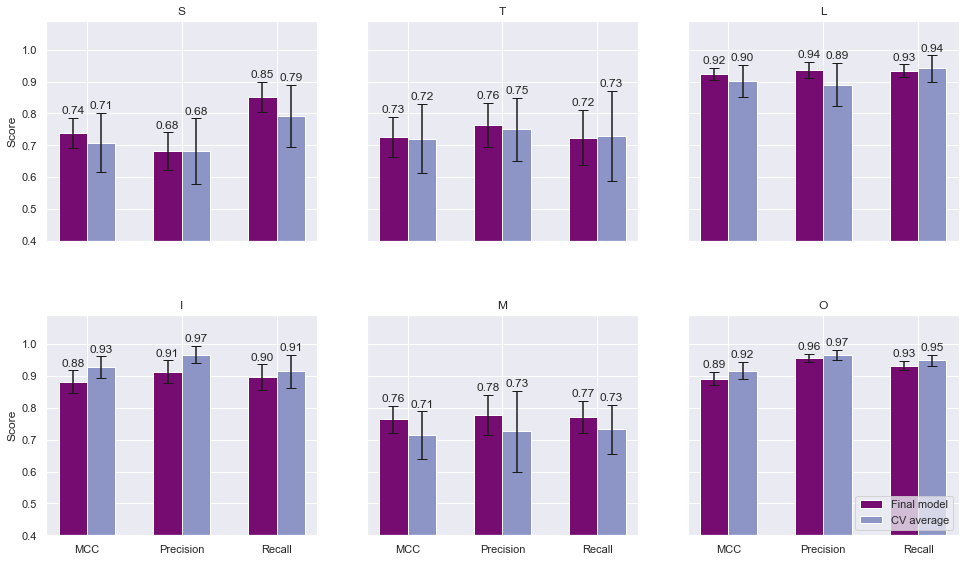

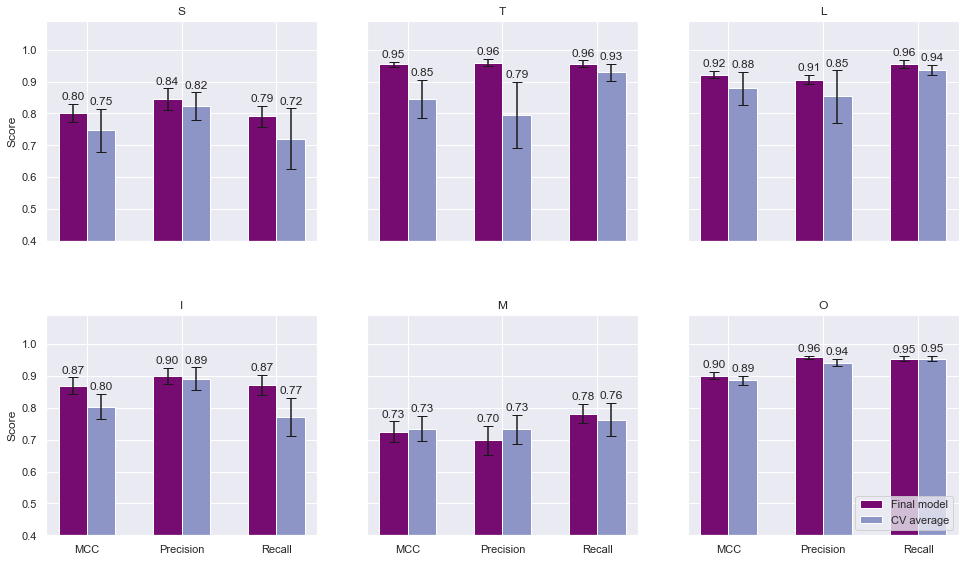

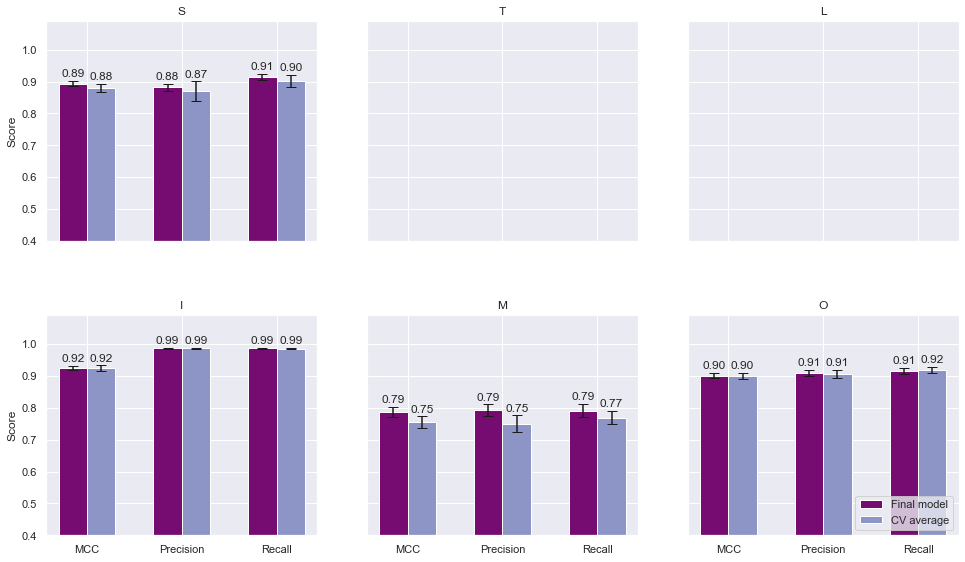

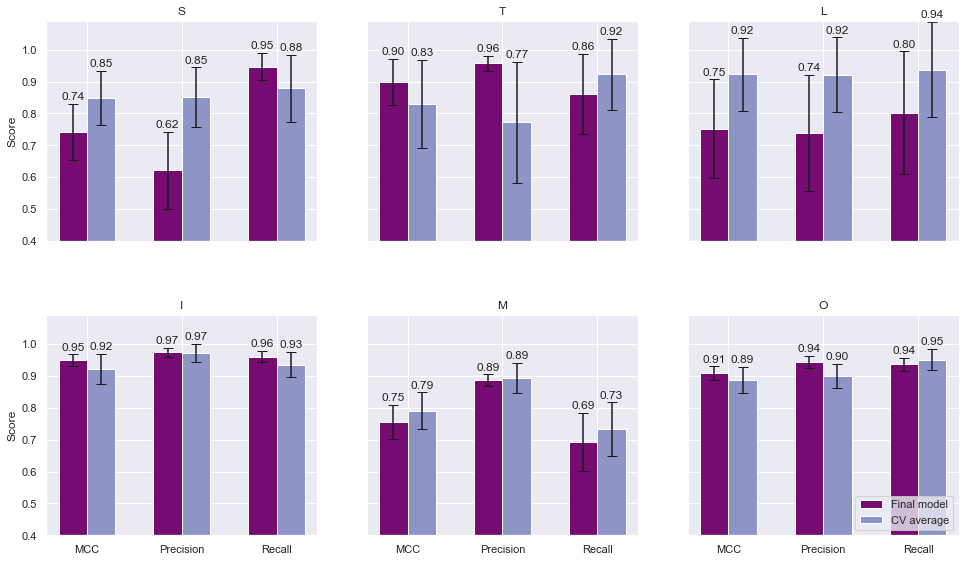

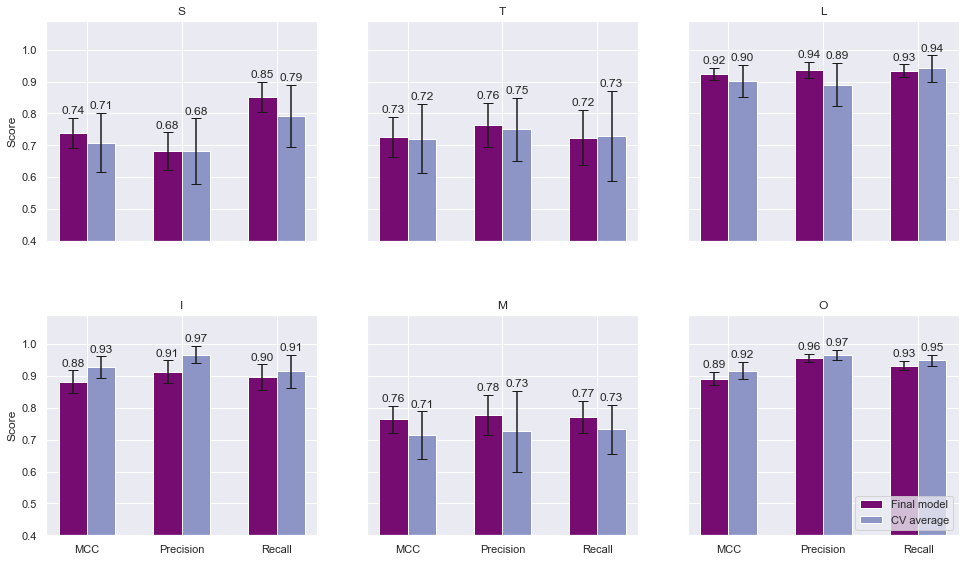

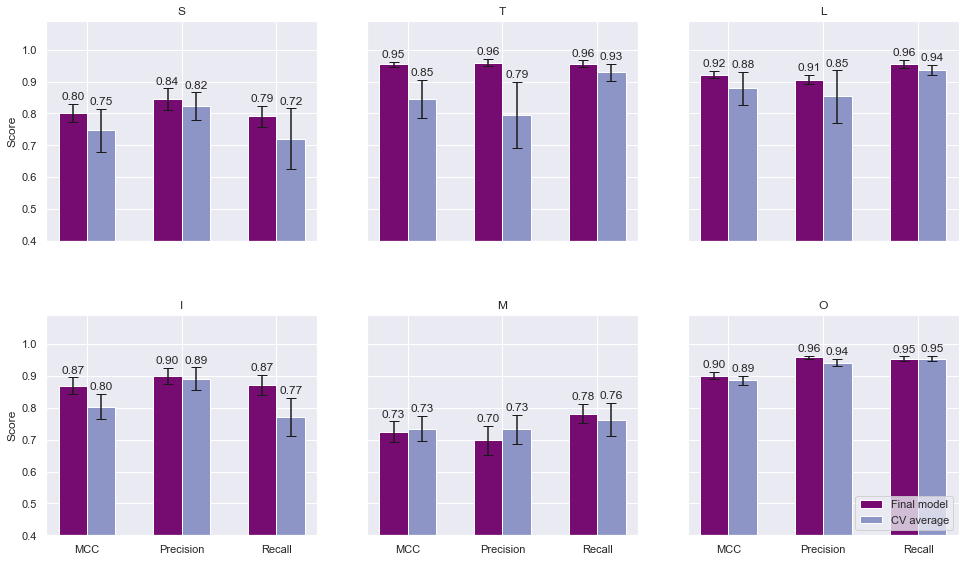

In [16]:

bar_width = 0.3
metrics = ["mcc", "precision", "recall"]
labels = ["MCC", "Precision", "Recall"]
classes = [c for c in "STLIMO"]
r1 = np.arange(len(metrics))
r2 = r1 + bar_width

for kingdom in KINGDOMS:
    fig = plt.figure()
    #fig.suptitle(kingdom)
    gs = fig.add_gridspec(2, 3)
    ((ax1, ax2, ax3), (ax4, ax5, ax6)) = gs.subplots(sharex="col", sharey="row")
    for ax, label in zip([ax1, ax2, ax3, ax4, ax5, ax6], classes):
        ax.set_title(label)
        final_values = ax.bar(
            r1,
            final_data.query(f"kingdom == '{kingdom}' and label == '{label}'")["mean"],
            yerr=final_data.query(f"kingdom == '{kingdom}' and label == '{label}'")["ci"],
            width=bar_width,
            color=final_color,
            label="Final model"
        )

        cv_values = ax.bar(
            r2,
            cv_average_data.query(f"kingdom == '{kingdom}' and label == '{label}'")["mean"],
            yerr=cv_average_data.query(f"kingdom == '{kingdom}' and label == '{label}'")["ci"],
            width=bar_width,
            color=cv_color,
            label="CV average"
        )

        ax.set_ylabel("Score")
        ax.set_xticks(r1 + bar_width/2)
        ax.set_xticklabels(labels)
        ax.set_ylim([0.4, 1.09])
        ax.label_outer()

        ax.bar_label(final_values, padding=2, fmt="%.2f")
        ax.bar_label(cv_values, padding=2, fmt="%.2f")

    plt.legend(loc="lower right")
    fig.tight_layout()
    fig.set_size_inches(15, 9)
    fig.savefig(f"output/performance_by_label_for_{kingdom}.png", dpi=240)